In [2]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import pandas as pd
from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline
import importlib as il
from tqdm import tqdm

import fast_time_interp

import pyIGRF as pyigrf
import apexpy
from apexpy import Apex

from multiprocessing import Pool
from itertools import repeat

os.cpu_count()

40

100%|██████████████████████████████████| 258508/258508 [11:36<00:00, 370.90it/s]


<xarray.Dataset>
Dimensions:        (sat_step: 86165, sami_time: 596)
Coordinates:
  * sami_time      (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
Dimensions without coordinates: sat_step
Data variables:
    sat_time       (sat_step) datetime64[ns] 2013-03-17 ... 2013-03-17T23:59:59
    lat            (sat_step) float64 48.02 48.08 48.14 ... 80.5 80.47 80.45
    lon            (sat_step) float64 252.0 252.0 251.9 ... 145.8 145.5 145.2
    alt            (sat_step) float64 859.4 859.4 859.4 ... 861.9 861.9 861.9
    edens          (sami_time, sat_step) float64 2.419e+04 2.419e+04 ... 0.0 0.0
    interpd_edens  (sat_step) float64 4.672e+04 4.673e+04 ... 2.22e+04 2.214e+04


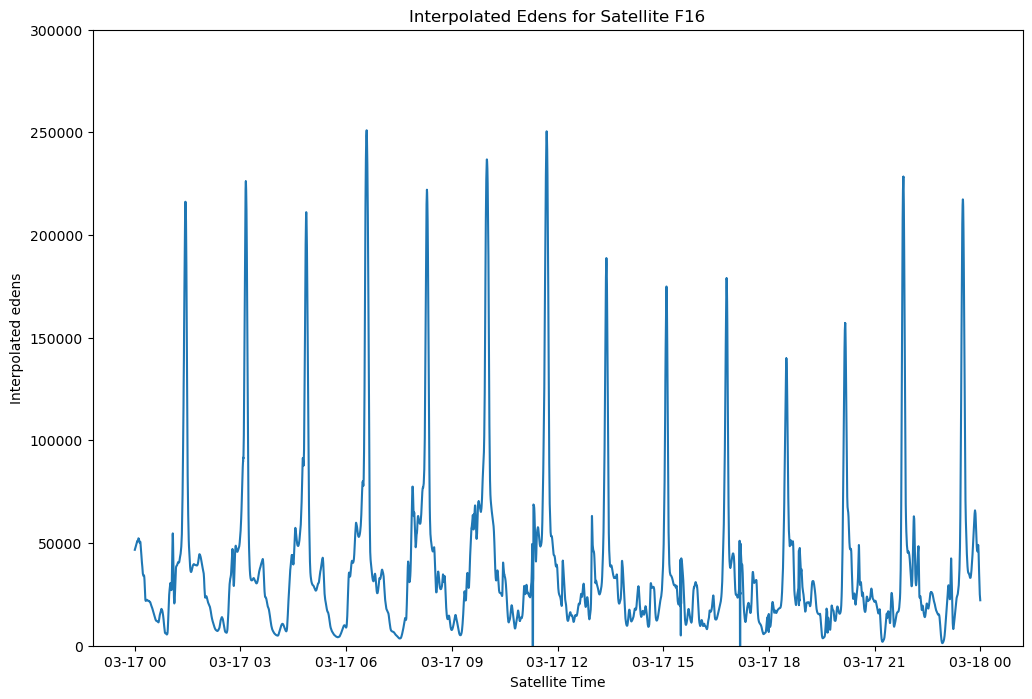

100%|██████████████████████████████████| 258531/258531 [11:48<00:00, 364.80it/s]


<xarray.Dataset>
Dimensions:        (sat_step: 86180, sami_time: 596)
Coordinates:
  * sami_time      (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
Dimensions without coordinates: sat_step
Data variables:
    sat_time       (sat_step) datetime64[ns] 2013-03-17 ... 2013-03-17T23:59:59
    lat            (sat_step) float64 65.15 65.09 65.04 ... 20.44 20.37 20.32
    lon            (sat_step) float64 106.7 106.7 106.6 ... 90.47 90.45 90.44
    alt            (sat_step) float64 851.4 851.4 851.4 ... 842.4 842.4 842.4
    edens          (sami_time, sat_step) float64 2.595e+04 2.595e+04 ... 0.0 0.0
    interpd_edens  (sat_step) float64 2.586e+04 2.584e+04 ... 2.278e+04


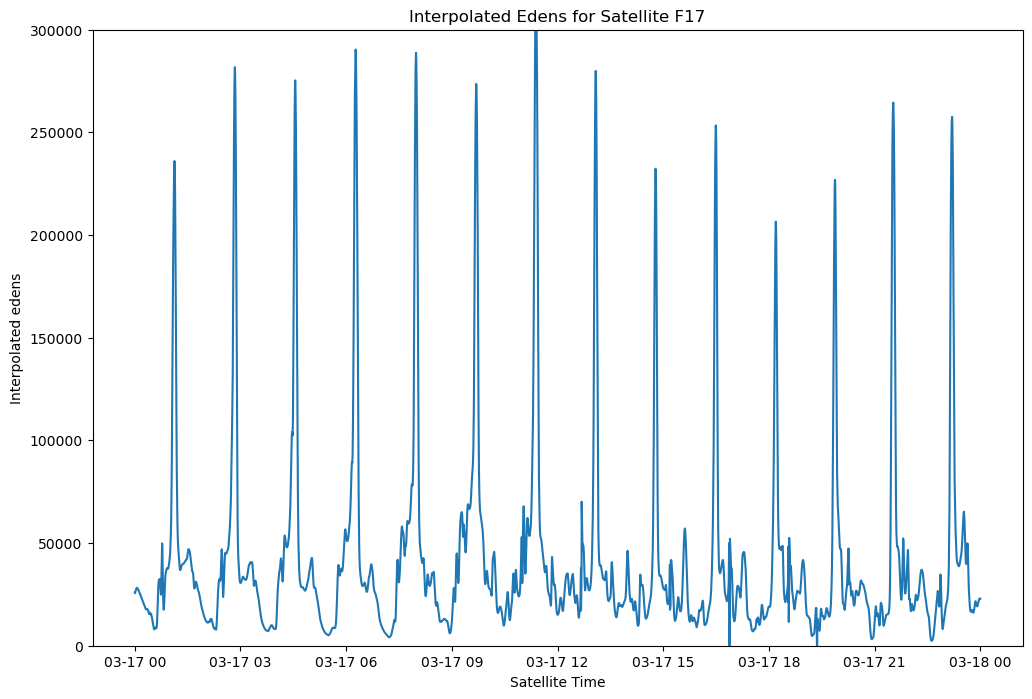

100%|██████████████████████████████████| 258585/258585 [11:45<00:00, 366.76it/s]


<xarray.Dataset>
Dimensions:        (sat_step: 86193, sami_time: 596)
Coordinates:
  * sami_time      (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
Dimensions without coordinates: sat_step
Data variables:
    sat_time       (sat_step) datetime64[ns] 2013-03-17 ... 2013-03-17T23:59:59
    lat            (sat_step) float64 56.6 56.66 56.72 ... 76.18 76.14 76.09
    lon            (sat_step) float64 288.3 288.2 288.2 ... 160.3 160.2 160.0
    alt            (sat_step) float64 853.5 853.6 853.7 ... 862.9 862.9 862.9
    edens          (sami_time, sat_step) float64 2.391e+04 2.391e+04 ... 0.0 0.0
    interpd_edens  (sat_step) float64 3.414e+04 3.411e+04 ... 2.264e+04


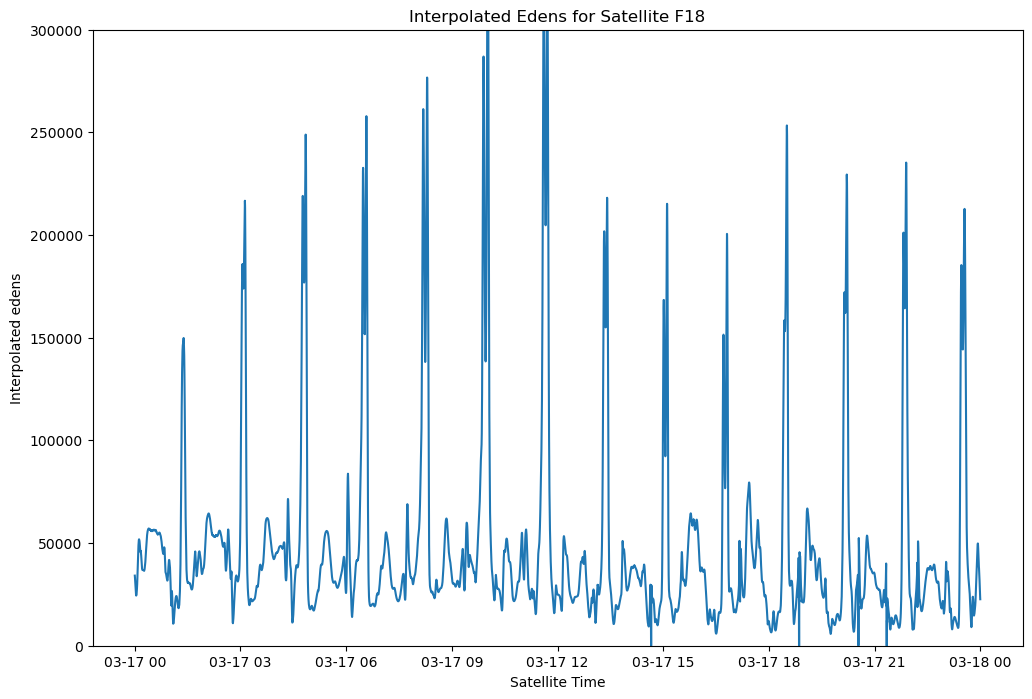

100%|███████████████████████████████████| 86193/86193 [00:18<00:00, 4709.87it/s]


In [12]:
paths = ['updated_sat_data/F16-fromraw_SAMI-REGRID.nc', 'updated_sat_data/F17-fromraw_SAMI-REGRID.nc', 'updated_sat_data/F18-fromraw_SAMI-REGRID.nc']
sat_name = ['F16', 'F17', 'F18']
fast_time_interp = il.reload(fast_time_interp)

for p, s_name in zip(paths, sat_name):
    satdf = xr.open_dataset(p)

    # Performing Interpolations
    interpolations = fast_time_interp.edens_sattime(satdf)
    satdf['interpd_edens'] = ('sat_step', interpolations)
    satdf = satdf.where(satdf.sat_time.dt.day == 17, drop='True')
    #satdf1 = satdf1.where(satdf1.sat_time.dt.day != 16, drop='True')
    
    print(satdf)
    
    plt.figure(figsize=(12,8))
    plt.plot(satdf['sat_time'], satdf['interpd_edens'])
    plt.xlabel('Satellite Time')
    plt.title('Interpolated Edens for Satellite ' + s_name)
    plt.ylabel('Interpolated edens')
    plt.ylim(0,300000)
    plt.show()

    # Calculating Magnetic Coordinates
    satdf = fast_time_interp.magnetic_coords(satdf)    
    satdf.to_netcdf('updated_sat_data/interpd_sat_data_' + s_name + '.nc')


# Calculating Magnetic Coordinates

F16 2013-03-17T00:00:00.000000000 2013-03-17T23:59:59.000000000


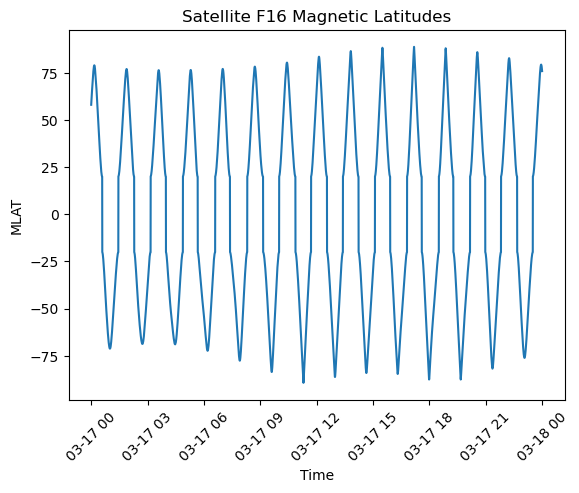

100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 14.78it/s]


F17 2013-03-17T00:00:00.000000000 2013-03-17T23:59:59.000000000


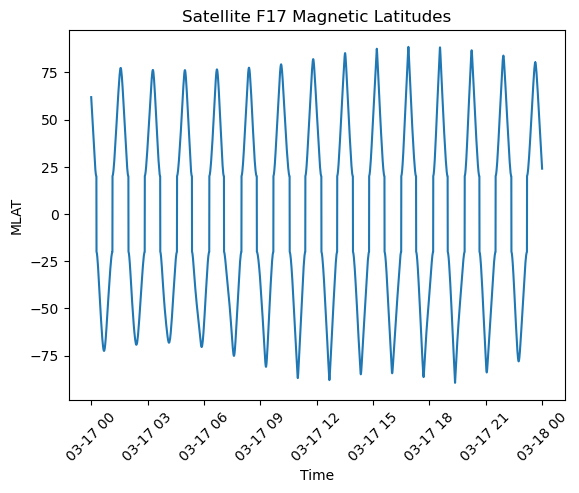

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 14.78it/s]


F18 2013-03-17T00:00:00.000000000 2013-03-17T23:59:59.000000000


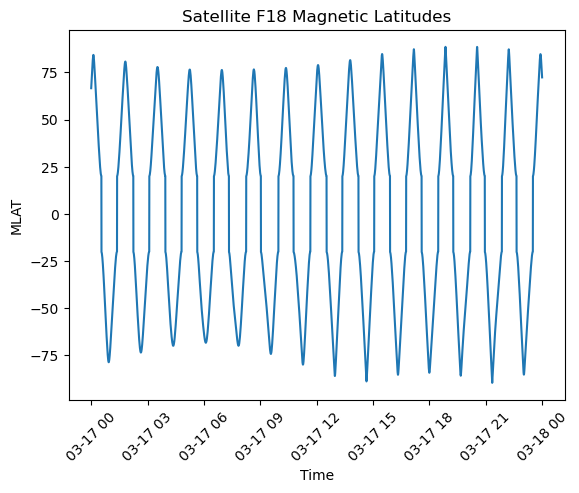

100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 15.16it/s]


In [17]:
paths = ['updated_sat_data/interpd_sat_data_F16.nc', 'updated_sat_data/interpd_sat_data_F17.nc', 'updated_sat_data/interpd_sat_data_F18.nc']
fast_time_interp = il.reload(fast_time_interp)

for p, s_name in zip(paths, sat_name):
    
    satdf =  xr.open_dataset(p)
    print(s_name, satdf['sat_time'][0].values,satdf['sat_time'][-1].values)


    mlat = satdf['mlat'].values

    plt.figure()
    plt.plot(satdf['sat_time'].values, mlat)
    plt.title('Satellite ' + s_name +  ' Magnetic Latitudes')
    plt.xlabel('Time')
    plt.ylabel('MLAT')
    plt.xticks(rotation=45)
    plt.show()

    
    # Removing Higher Latitudes. Targetting -55 to 55 degrees. 
    # Keeping a margin of 10 degrees on both sides
    
    set = False
    ascending = []
    descending = []

    start = 0
    end = 0

    # Ascending passes
    for i in tqdm(range(len(mlat)-1)):
        if mlat[i] <= -65 and mlat[i+1] > -65:
            start = i
            set = True
            
        if set and mlat[i] <= 65 and mlat[i+1] > 65:
            set = False
            end = i
            ascending.append((start,end))

    for i in tqdm(range(len(ascending))):
        
        start, end = ascending[i]
        sat_pass = satdf.isel(sat_step=slice(start, end+1))
        path = 'updated_sat_data/ascending_passes/' + str(i) + '_' + s_name + '_pass.nc'
        sat_pass.to_netcdf(path)

    start = 0
    end = 0
    # Descending passes
    for i in tqdm(range(len(mlat)-1)):
        if mlat[i] >= 65 and mlat[i+1] < 65:
            start = i
            set = True
            
        if set and mlat[i] >= -65 and mlat[i+1] < -65:
            set = False
            end = i
            descending.append((start,end))
    
    for i in tqdm(range(len(descending))):
        start, end = descending[i]
        sat_pass = satdf.isel(sat_step=slice(start, end+1))
        path = 'updated_sat_data/descending_passes/' + str(i) + '_' + s_name + '_pass.nc'
        sat_pass.to_netcdf(path)


# --- Code Finished ---

# Unrefined - Old Code

In [3]:
path_to_sat_files = 'temp/F18_2013_75-77_interped_SAMI-INTERP.nc'

satdf = xr.open_dataset(path_to_sat_files)

print(satdf)

'''
# Check for the first satellite passing on 17 March
satdf = satdf.where(satdf.sat_time.dt.day == 17, drop = 'True')

satdf = satdf.isel(sat_step=slice(62177, 63971))
print(satdf)
''';

<xarray.Dataset>
Dimensions:    (sami_time: 596, sat_step: 258585)
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
    glat       (sat_step) float64 ...
    glon       (sat_step) float64 ...
    alt        (sat_step) float64 ...
    sat_time   (sat_step) datetime64[ns] ...
Dimensions without coordinates: sat_step
Data variables:
    edens      (sami_time, sat_step) float64 ...


In [41]:
fast_time_interp = il.reload(fast_time_interp)

interpolations = fast_time_interp.edens_sattime(satdf)

# if you want to do it for a specific date then mention the date as the second argument

#interpolations = fast_time_interp.edens_sattime(satdf, 17)


100%|██████████████████████████████████| 258585/258585 [12:50<00:00, 335.78it/s]


258585
<xarray.Dataset>
Dimensions:    (sami_time: 596, sat_step: 258585)
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
    glat       (sat_step) float64 ...
    glon       (sat_step) float64 ...
    alt        (sat_step) float64 ...
    sat_time   (sat_step) datetime64[ns] ...
Dimensions without coordinates: sat_step
Data variables:
    edens      (sami_time, sat_step) float64 ...
<xarray.Dataset>
Dimensions:        (sami_time: 596, sat_step: 86193)
Coordinates:
  * sami_time      (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
    glat           (sat_step) float64 56.6 56.7 56.7 56.8 ... 76.2 76.1 76.1
    glon           (sat_step) float64 288.3 288.2 288.2 ... 160.3 160.2 160.0
    alt            (sat_step) float64 853.5 853.6 853.7 ... 862.9 862.9 862.9
    sat_time       (sat_step) datetime64[ns] 2013-03-17 ... 2013-03-17T23:59:59
Dimensions without coordinates: sat_step
Data variables:
    edens          (sami_time, sat_st

(0.0, 300000.0)

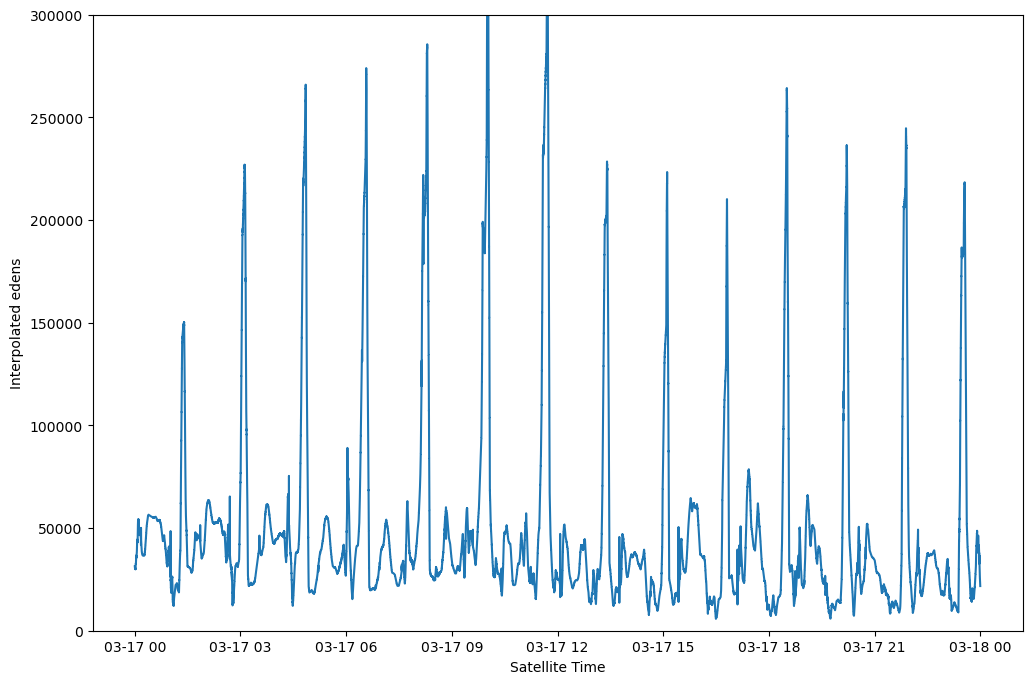

In [42]:
print(len(interpolations))
print(satdf)

satdf['interpd_edens'] = ('sat_step', interpolations)

satdf1 = satdf.where(satdf.sat_time.dt.day != 18, drop='True')
satdf1 = satdf1.where(satdf1.sat_time.dt.day != 16, drop='True')

print(satdf1)

plt.figure(figsize=(12,8))
plt.plot(satdf1['sat_time'], satdf1['interpd_edens'])
plt.xlabel('Satellite Time')
plt.ylabel('Interpolated edens')
plt.ylim(0,300000)


In [43]:
satdf1.to_netcdf('time_interpolated_data/sat_data_F18.nc')

# Calculating the Magnetic Coordinates

In [44]:
satdf = xr.open_dataset('time_interpolated_data/sat_data_F18.nc')
print(satdf)

<xarray.Dataset>
Dimensions:        (sat_step: 86193, sami_time: 596)
Coordinates:
    glat           (sat_step) float64 ...
    glon           (sat_step) float64 ...
    alt            (sat_step) float64 ...
    sat_time       (sat_step) datetime64[ns] ...
  * sami_time      (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
Dimensions without coordinates: sat_step
Data variables:
    interpd_edens  (sat_step) float64 ...
    edens          (sami_time, sat_step) float64 ...


(0.0, 300000.0)

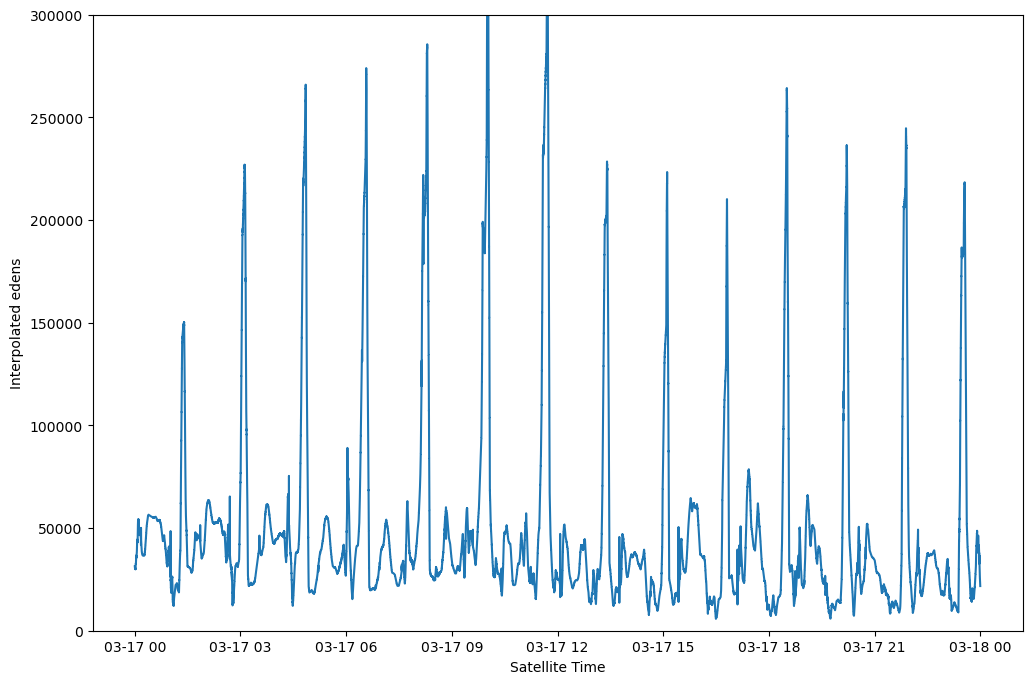

In [45]:
satdf = satdf.where(satdf.sat_time.dt.day == 17, drop='True')

plt.figure(figsize=(12,8))
plt.plot(satdf['sat_time'], satdf['interpd_edens'])
plt.xlabel('Satellite Time')
plt.ylabel('Interpolated edens')
plt.ylim(0,300000)

In [46]:
fast_time_interp = il.reload(fast_time_interp)

sat_mag = fast_time_interp.magnetic_coords(satdf)
sat_mag.to_netcdf('time_interpolated_data/sat_data_F18.nc')


sat_mag1 = fast_time_interp.magnetic_coords(satdf1)
sat_mag1.to_netcdf('time_interpolated_data/sat_data_F18_day_17.nc')

sat_mag1

100%|███████████████████████████████████| 86193/86193 [00:17<00:00, 4977.61it/s]


<xarray.Dataset>
Dimensions:        (sami_time: 596, sat_step: 86193)
Coordinates:
  * sami_time      (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
    glat           (sat_step) float64 56.6 56.7 56.7 56.8 ... 76.2 76.1 76.1
    glon           (sat_step) float64 288.3 288.2 288.2 ... 160.3 160.2 160.0
    alt            (sat_step) float64 853.5 853.6 853.7 ... 862.9 862.9 862.9
    sat_time       (sat_step) datetime64[ns] 2013-03-17 ... 2013-03-17T23:59:59
Dimensions without coordinates: sat_step
Data variables:
    edens          (sami_time, sat_step) float64 0.0 0.0 ... 3.623e+04 3.608e+04
    interpd_edens  (sat_step) float64 3.136e+04 3.13e+04 ... 2.182e+04 2.175e+04
    mlat           (sat_step) float64 66.63 66.73 66.73 ... 72.49 72.39 72.38
    mlon           (sat_step) float64 7.9 7.77 7.77 ... -142.0 -142.0 -142.1

In [9]:
satf = xr.open_dataset('time_interpolated_data/sat_data_F16_day_17.nc')
satf

<xarray.Dataset>
Dimensions:        (sat_step: 86165, sami_time: 596)
Coordinates:
    glat           (sat_step) float64 ...
    glon           (sat_step) float64 ...
    alt            (sat_step) float64 ...
    sat_time       (sat_step) datetime64[ns] ...
  * sami_time      (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
Dimensions without coordinates: sat_step
Data variables:
    interpd_edens  (sat_step) float64 ...
    mlat           (sat_step) float64 ...
    mlon           (sat_step) float64 ...
    edens          (sami_time, sat_step) float64 ...

In [10]:
print(satf['sat_time'][0].values,satf['sat_time'][-1].values)

2013-03-17T00:00:00.000000000 2013-03-17T23:59:59.000000000


100%|███████████████████████████████████| 86164/86164 [01:05<00:00, 1308.89it/s]


[(4162, 6120), (10346, 12311), (16568, 18466), (22774, 24576), (28951, 30665), (35082, 36753), (41182, 42844), (47237, 48938), (53275, 55031), (59309, 61108), (65321, 67156), (71324, 73175), (77352, 79198), (83423, 85316)]


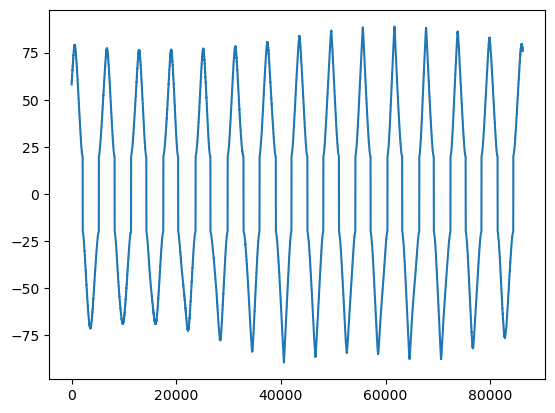

In [11]:

mlat = satf['mlat']

plt.plot(mlat)

set = False
coords = []
for i in tqdm(range(len(mlat)-1)):
    if mlat[i] >= 55 and mlat[i+1] < 55:
        start = i
        set = True
    if set and mlat[i] >= -55 and mlat[i+1] < -55:
        set = False
        end = i
        coords.append((start,end))

print(coords)

In [12]:

print(len(coords))
s = []
for i in tqdm(range(len(coords))):
    start, end = coords[i]
    sat_t = satf.isel(sat_step=slice(start, end+1))
    path = 'time_interpolated_data/descending_pass' + str(i) + '_F16_passing.nc'
    sat_t.to_netcdf(path)


14


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 15.36it/s]


# Writing the code for the satellite passes

In [48]:
pass_day = 17
pass_num = 1


def sat_pass(sat_data, day, num):
    
    sat_data.where(sat_data.dt.data == pass_day, drop = True)
    
    mlat = sat_data['mlat']
    
    print(np.where(mlat > 55 and mlat < 54.9))
    return

sat_pass(satdf, 17, num)

    